In [1]:
import os
os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA, NMF
from matplotlib import animation
from scipy.ndimage import gaussian_filter, convolve1d
from scipy.signal import convolve2d
from skimage import io

# for cvNMF
import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

from devenw.nmf import poiss_train, censored_lstsq, censored_nnlstsq, cv_pca, downsample_tiff_avg, plot_nmf_t, plot_nmf_px


# Defining parameters

In [2]:
# dataset and downsampling
ds = 'ani98_XXXX-XX-XX_a'
downs_fact = 8 # put to 1 for no downsampling

In [3]:
# cross-validated nmf
r_min = 1
r_max = 100 # 200
num_r = 30 # 30

replicates = 1 # can be run multiple times for robustness (1 means no replication)

# Preparing data (loading and downsampling)

file000_chan0.tif
(500, 405, 405)
file001_chan0.tif
(500, 405, 405)
(1000, 405, 405)
file002_chan0.tif
(500, 405, 405)
(1500, 405, 405)
file003_chan0.tif
(500, 405, 405)
(2000, 405, 405)
file004_chan0.tif
(500, 405, 405)
(2500, 405, 405)
file005_chan0.tif
(500, 405, 405)
(3000, 405, 405)
file006_chan0.tif
(500, 405, 405)
(3500, 405, 405)
file007_chan0.tif
(100, 405, 405)
(3600, 405, 405)
Shape of video: (3600, 405, 405)


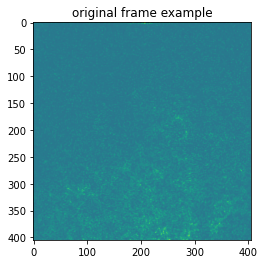

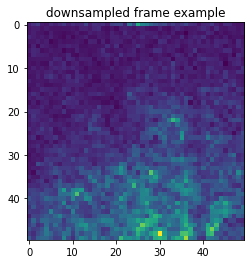

Shape of re_shaped video: (3600, 2500)


In [4]:
# get list of tiffs
tiff_all = []
for (i, ti) in enumerate(os.listdir(f'data/{ds}/suite2p/plane0/reg_tif')):
    print(ti)
    if i == 0:
        tiff = io.imread(f'data/{ds}/suite2p/plane0/reg_tif/{ti}',  plugin='pil') # initialise tiff
    else:
        tiff_i = io.imread(f'data/{ds}/suite2p/plane0/reg_tif/{ti}',  plugin='pil')
        tiff = np.concatenate((tiff, tiff_i))
        print(tiff_i.shape)
    print(tiff.shape)

# making sure smallest value of tiff is zero - just a linear transform, shouldn't affect NMF
tiff -= np.min(tiff)
        

print(f'Shape of video: {tiff.shape}') 
n_frames = tiff.shape[0] 
x_axis = tiff.shape[1]
y_axis = tiff.shape[2]

# downsample for cross-validation # IMPORTANT: downsampling will mean fewer components are significant (but same goes for imaging at lower res.)
tiff =downsample_tiff_avg(tiff, n=downs_fact)

tiff_flat = np.reshape(tiff, (n_frames, tiff.shape[1]*tiff.shape[2]))
print(f'Shape of re_shaped video: {tiff_flat.shape}') 

# Cross-validated NMF

In [5]:
ranks = np.logspace(np.log10(r_min), np.log10(r_max), num=num_r) # log spaced r parameter to test with cross-validation
ranks = np.unique(np.round(ranks)).astype(int)
print('Selected r values to test using cross-validation: ', ranks)

Selected r values to test using cross-validation:  [  1   2   3   4   5   6   7   8   9  11  13  15  17  20  24  28  33  39
  45  53  62  73  85 100]


In [6]:
data = tiff_flat
train_err, test_err = [], []

# fit models
count=0
for rnk, _ in itertools.product(ranks, range(replicates)):
    count+=1
    print(f'Running nmf for rank {rnk} with max rank, with max rank {np.max(ranks)} (run {count} out of {len(ranks)})')
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    
    

Running nmf for rank 1 with max rank, with max rank 100 (run 1 out of 24)
Running nmf for rank 2 with max rank, with max rank 100 (run 2 out of 24)
Running nmf for rank 3 with max rank, with max rank 100 (run 3 out of 24)
Running nmf for rank 4 with max rank, with max rank 100 (run 4 out of 24)
Running nmf for rank 5 with max rank, with max rank 100 (run 5 out of 24)
Running nmf for rank 6 with max rank, with max rank 100 (run 6 out of 24)
Running nmf for rank 7 with max rank, with max rank 100 (run 7 out of 24)
Running nmf for rank 8 with max rank, with max rank 100 (run 8 out of 24)
Running nmf for rank 9 with max rank, with max rank 100 (run 9 out of 24)
Running nmf for rank 11 with max rank, with max rank 100 (run 10 out of 24)
Running nmf for rank 13 with max rank, with max rank 100 (run 11 out of 24)
Running nmf for rank 15 with max rank, with max rank 100 (run 12 out of 24)
Running nmf for rank 17 with max rank, with max rank 100 (run 13 out of 24)
Running nmf for rank 20 with m

In [7]:
train_err_np = np.array([train_err[i][1] for i in range(len(train_err))])
test_err_np = np.array([test_err[i][1] for i in range(len(test_err))])

opt_r = ranks[np.argmin(test_err_np)]
print('Estimated optimal r from cross-validation:', opt_r)

Estimated optimal r from cross-validation: 24


In [8]:
# setting (and optionally creating) save path
save_path = os.getcwd() + '/data/' + ds + '/patch_sz/'

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    
print('SavePath: ', save_path)

SavePath:  E:\deve-networks/data/ani98_XXXX-XX-XX_a/patch_sz/


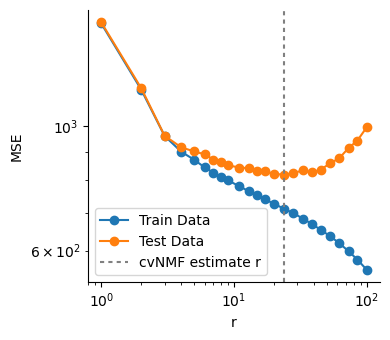

In [9]:
# make plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), dpi=100)
#ax.plot(train_err_np[:], 'o-', label='Train Data') # without 'average' component
ax.loglog(ranks, train_err_np[:], 'o-', label='Train Data') # without 'average' component
ax.loglog(ranks, test_err_np[:], 'o-', label='Test Data') # without 'average' component
ax.set_ylabel('MSE')
ax.set_xlabel('r')
ax.axvline(opt_r, color='grey', dashes=[2,2], label='cvNMF estimate r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
fig.tight_layout()

plt.savefig(os.getcwd() + f'/data/{ds}/patch_sz/cvNMF_train_test.png')
